# Spatial Filter做法
1. (Laplacian filter)

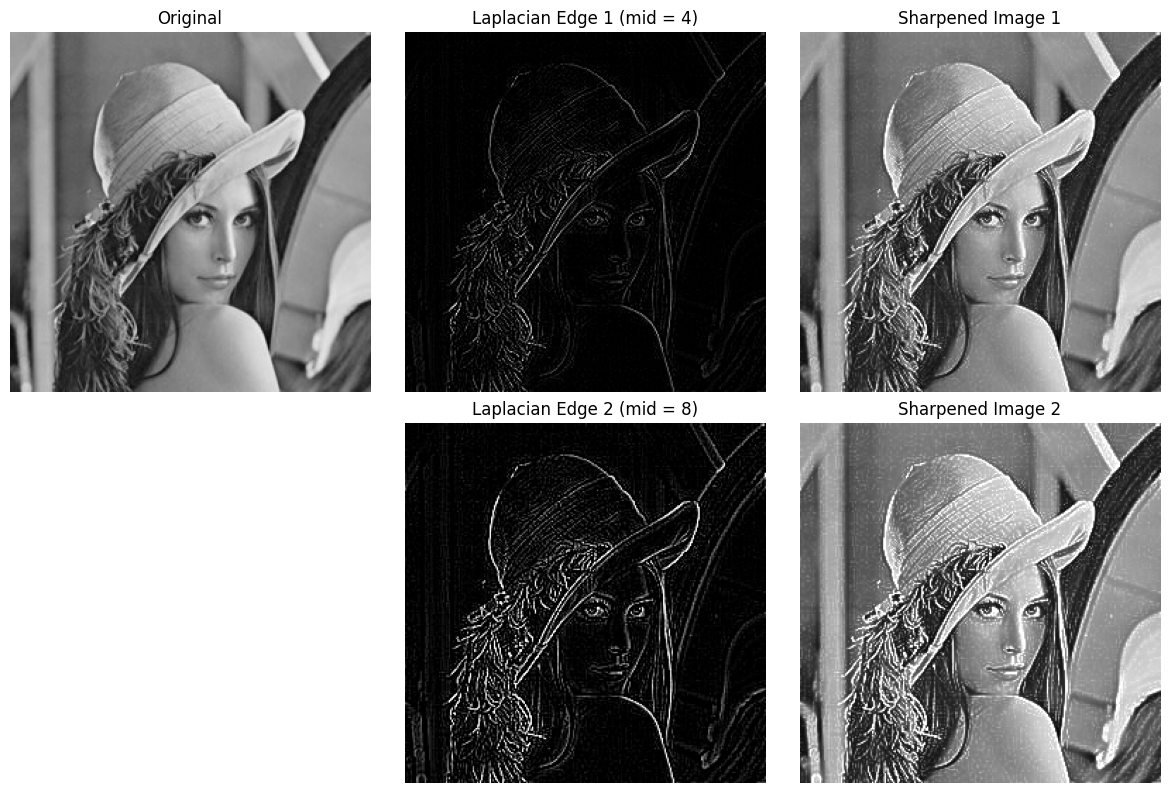

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖像（轉為灰階）
img = cv2.imread('len_std.jpg', cv2.IMREAD_GRAYSCALE)

# 定義 Laplacian 核心
laplacian_kernel = np.array([
    [0, -1,  0],
    [-1, 4, -1],
    [0, -1,  0]
], dtype=np.float32)

laplacian_kernel_2 = np.array([
    [-1, -1,  -1],
    [-1, 8, -1],
    [-1, -1,  -1]
], dtype=np.float32)

# 套用 Laplacian filter（邊緣圖）
laplacian_edge = cv2.filter2D(img, -1, laplacian_kernel)
laplacian_edge_2 = cv2.filter2D(img, -1, laplacian_kernel_2)

# 做銳化：原圖 + 邊緣圖
sharpened = cv2.add(img, laplacian_edge)
sharpened_2 = cv2.add(img, laplacian_edge_2)

# 顯示結果
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Laplacian Edge 1 (mid = 4)")
plt.imshow(laplacian_edge, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Sharpened Image 1")
plt.imshow(sharpened, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Laplacian Edge 2 (mid = 8)")
plt.imshow(laplacian_edge_2, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Sharpened Image 2")
plt.imshow(sharpened_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 儲存 Laplacian 邊緣圖和銳化後的圖像
cv2.imwrite('laplacian_edge_1(mid=4).jpg', laplacian_edge)
cv2.imwrite('laplacian_edge_2(mid=8).jpg', laplacian_edge_2)
cv2.imwrite('laplacian_sharpened_1.jpg', sharpened)
cv2.imwrite('laplacian_sharpened_2.jpg', sharpened_2)

2. 用Sobel filter找edge

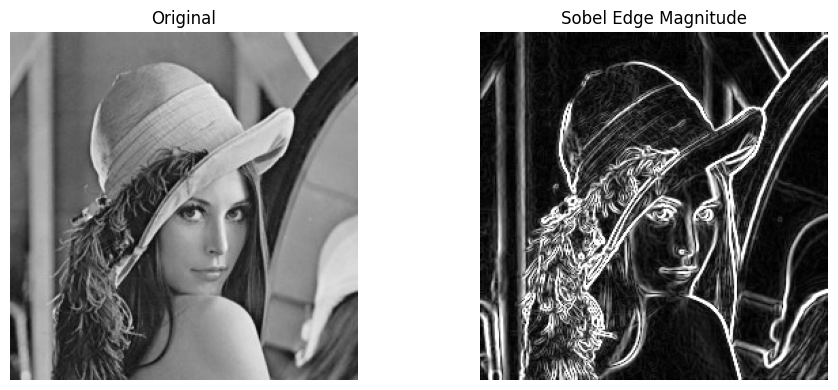

In [12]:
import cv2
import matplotlib.pyplot as plt

# 讀取灰階圖像
img = cv2.imread('len_std.jpg', cv2.IMREAD_GRAYSCALE)

# 使用Sobel過濾器計算 x 和 y 方向的梯度
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # X方向
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Y方向

# 計算梯度強度 (邊緣強度)
sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)

# 將結果轉成 0~255 並轉成 uint8
sobel_magnitude = cv2.convertScaleAbs(sobel_magnitude)

# 顯示結果
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Sobel Edge Magnitude')
plt.imshow(sobel_magnitude, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

- Numpy version

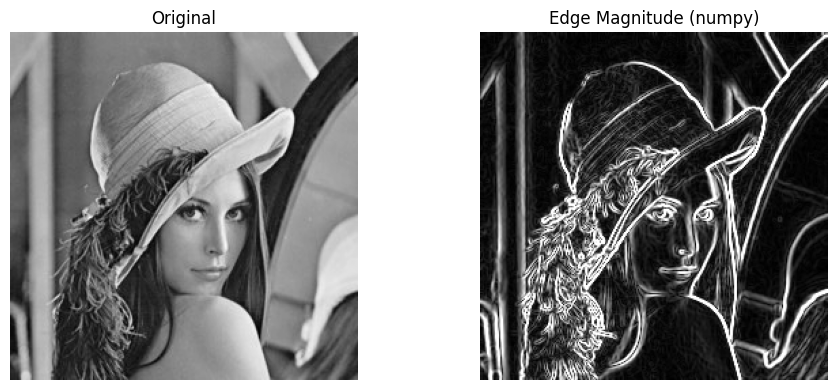

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import convolve

# 讀取圖片並轉成灰階
img = Image.open('len_std.jpg').convert('L')
img_array = np.array(img, dtype=np.float32)

# 定義 Sobel kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

sobel_y = np.array([[ 1,  2,  1],
                    [ 0,  0,  0],
                    [-1, -2, -1]], dtype=np.float32)

# 卷積運算
grad_x = convolve(img_array, sobel_x)
grad_y = convolve(img_array, sobel_y)

# 計算邊緣強度 (magnitude)
edge_magnitude = np.sqrt(grad_x**2 + grad_y**2)
edge_magnitude = np.clip(edge_magnitude, 0, 255).astype(np.uint8)

# 顯示結果
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Edge Magnitude (numpy)')
plt.imshow(edge_magnitude, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

- mean filter去雜訊

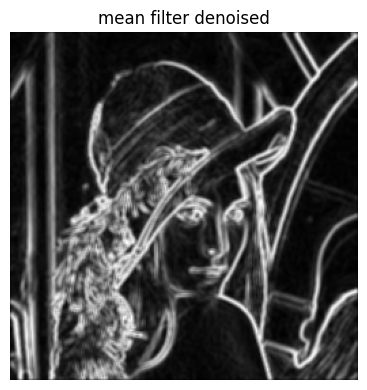

In [14]:
def mean_filter(img_array, kernel_size=3):

    # Padding (避免邊界資料遺失)
    padded_img = np.pad(img_array, pad_width=kernel_size // 2, mode='constant', constant_values=0)

    # 準備輸出圖像
    output = np.zeros_like(img_array)

    # 手動套用 3x3 mean filter
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            region = padded_img[i:i+kernel_size, j:j+kernel_size]  # 取出 kernel 區域
            mean_value = np.mean(region)      # 計算均值
            output[i, j] = mean_value         # 存到輸出圖

    # 將結果轉為 uint8 顯示
    output = np.clip(output, 0, 255).astype(np.uint8)
    
    return output


denoised_img = mean_filter(edge_magnitude)

plt.figure(figsize=(5, 4))
plt.subplot(1, 1, 1)
plt.title('mean filter denoised')
plt.imshow(denoised_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

- 標準化並加上laplacian edge

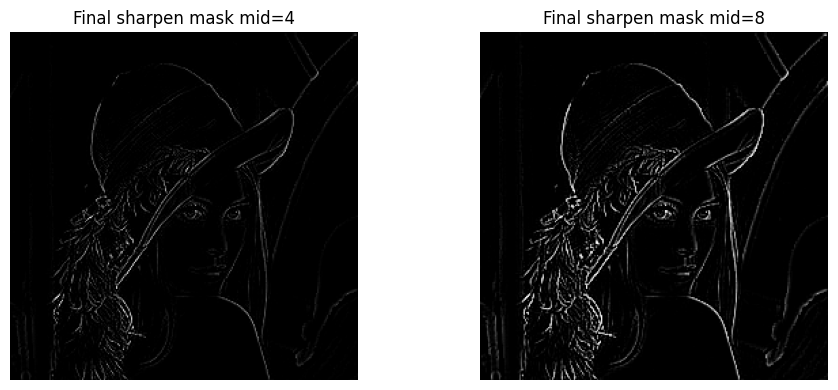

In [22]:
def normalize_and_multiply(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    將影像 A 正規化到 [0.0, 1.0]，然後乘上影像 B。
    假設 A 和 B 是同樣大小的 numpy array。

    Parameters:
        A (np.ndarray): 要正規化的影像
        B (np.ndarray): 要相乘的影像

    Returns:
        np.ndarray: 結果影像 (同 A, B 尺寸)
    """
    if A.shape != B.shape:
        raise ValueError("A 和 B 必須有相同的尺寸")

    A_min = np.min(A)
    A_max = np.max(A)

    # 避免除以零
    if A_max - A_min == 0:
        A_norm = np.zeros_like(A, dtype=np.float32)
    else:
        A_norm = (A - A_min) / (A_max - A_min)

    # 確保 B 是 float 格式再做乘法
    result = (A_norm * B.astype(np.float32)).astype(np.float32)

    return result

final_sharpen_mask = normalize_and_multiply(denoised_img, laplacian_edge)
final_sharpen_mask_2 = normalize_and_multiply(denoised_img, laplacian_edge_2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Final sharpen mask mid=4')
plt.imshow(final_sharpen_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Final sharpen mask mid=8')
plt.imshow(final_sharpen_mask_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

- 最後將sharpen mask加回原圖

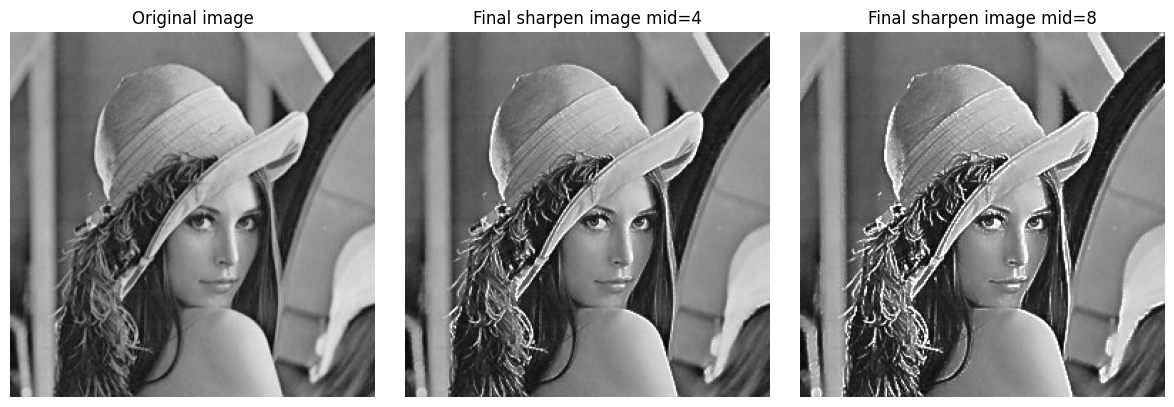

In [31]:
final_sharpen_img = cv2.add(img_array, final_sharpen_mask)
final_sharpen_img = np.clip(final_sharpen_img, 0, 255).astype(np.uint8)
final_sharpen_img_2 = cv2.add(img_array, final_sharpen_mask_2)
final_sharpen_img_2 = np.clip(final_sharpen_img_2, 0, 255).astype(np.uint8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Final sharpen image mid=4')
plt.imshow(final_sharpen_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final sharpen image mid=8')
plt.imshow(final_sharpen_img_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

- 儲存final mask and final sharpened image

In [30]:
cv2.imwrite('Final_sharpen_mask_1.jpg', final_sharpen_mask)
cv2.imwrite('Final_sharpen_mask_2.jpg', final_sharpen_mask_2)
cv2.imwrite('Final_sharpen_1.jpg', final_sharpen_img)
cv2.imwrite('Final_sharpen_2.jpg', final_sharpen_img_2)

True

# Deep learning做法(採用realesrgan)
> 使用Python檔inference失敗(torchvision版本不相容)

In [29]:
%cd "D:\DIP-HW\HW3\Real-ESRGAN"
%run inference_realesrgan.py -i ../len_std.jpg -o ../gan_out_py.jpg --face_enhance --ext auto --fp32

D:\DIP-HW\HW3\Real-ESRGAN


ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'

使用exe檔執行(成功)

In [33]:
%cd "D:\DIP-HW\HW3\realesrgan"
!realesrgan-ncnn-vulkan.exe -i ../len_std.jpg -o ../gan_out.jpg -n realesrgan-x4plus -f jpg

D:\DIP-HW\HW3\realesrgan


[0 NVIDIA GeForce RTX 5070]  queueC=2[8]  queueG=0[16]  queueT=1[2]
[0 NVIDIA GeForce RTX 5070]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[0 NVIDIA GeForce RTX 5070]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[0 NVIDIA GeForce RTX 5070]  subgroup=32  basic=1  vote=1  ballot=1  shuffle=1
[1 AMD Radeon(TM) Graphics]  queueC=1[2]  queueG=0[1]  queueT=2[1]
[1 AMD Radeon(TM) Graphics]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[1 AMD Radeon(TM) Graphics]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[1 AMD Radeon(TM) Graphics]  subgroup=64  basic=1  vote=1  ballot=1  shuffle=1
0.00%
25.00%
50.00%
75.00%
